# Análise Exploratória de Dados (EDA) - Camada Bronze Olist

**Autor:** Diego Carlito Rodrigues de Souza
**Matrícula:** 221007690

**Objetivo:** Realizar uma análise exploratória nos dados brutos do dataset Olist para entender a estrutura, qualidade e
distribuição dos dados, informando o desenvolvimento do pipeline de ETL.

In [1]:
from pyspark.sql import SparkSession, DataFrame
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
spark = SparkSession.builder \
    .appName("AnaliseExploratoriaOlist") \
    .getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/10 23:48:56 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
def carregar_dados_bronze(spark, caminho_base, arquivos_csv):
    """Carrega múltiplos arquivos CSV da camada bronze e retorna um dicionário de DataFrames."""
    dataframes = {}
    for arquivo in arquivos_csv:
        nome_chave = arquivo.replace(".csv", "").replace("_dataset", "")
        caminho_completo = f"{caminho_base}{arquivo}"
        df = spark.read.csv(caminho_completo, header=True, inferSchema=True)
        dataframes[nome_chave] = df
    return dataframes

def analisar_valores_nulos(df: DataFrame, nome_df: str):
    """Analisa e imprime a contagem de valores nulos para cada coluna de um DataFrame."""
    print(f"\n--- Análise de Nulos: {nome_df} ---")
    resultados_nulos = df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns]).first()
    
    colunas_com_nulos = False
    for coluna in df.columns:
        contagem = resultados_nulos[coluna]
        if contagem > 0:
            print(f"Coluna '{coluna}': {contagem} valores nulos.")
            colunas_com_nulos = True
            
    if not colunas_com_nulos:
        print("Nenhuma coluna com valores nulos.")

In [4]:
caminho_base_dados = "../data/bronze/"
lista_arquivos = [
    "olist_customers_dataset.csv", "olist_geolocation_dataset.csv", 
    "olist_order_items_dataset.csv", "olist_order_payments_dataset.csv",
    "olist_order_reviews_dataset.csv", "olist_orders_dataset.csv",
    "olist_products_dataset.csv", "olist_sellers_dataset.csv",
    "product_category_name_translation.csv"
]

dfs = carregar_dados_bronze(spark, caminho_base_dados, lista_arquivos)

print("DataFrames carregados com sucesso:")
for nome in dfs.keys():
    print(f"- {nome}")

DataFrames carregados com sucesso:
- olist_customers
- olist_geolocation
- olist_order_items
- olist_order_payments
- olist_order_reviews
- olist_orders
- olist_products
- olist_sellers
- product_category_name_translation


## 1. Análise Geral e Estrutura dos Dados
Nesta seção, vamos iterar sobre cada DataFrame carregado para inspecionar seu schema, ver uma amostra dos dados e
verificar a presença de valores nulos.

In [5]:
for nome, df in dfs.items():
    print(f"\n{'='*20} Análise do DataFrame: {nome.upper()} {'='*20}")
    print(f"Total de Linhas: {df.count()}")
    print("\nSchema:")
    df.printSchema()
    print("\nAmostra dos Dados:")
    df.show(5, truncate=False)
    analisar_valores_nulos(df, nome)


==================== Análise do DataFrame: OLIST_CUSTOMERS ====================
Total de Linhas: 99441

Schema:
root
 |-- customer_id: string (nullable = true)
 |-- customer_unique_id: string (nullable = true)
 |-- customer_zip_code_prefix: integer (nullable = true)
 |-- customer_city: string (nullable = true)
 |-- customer_state: string (nullable = true)


Amostra dos Dados:
+--------------------------------+--------------------------------+------------------------+---------------------+--------------+
|customer_id                     |customer_unique_id              |customer_zip_code_prefix|customer_city        |customer_state|
+--------------------------------+--------------------------------+------------------------+---------------------+--------------+
|06b8999e2fba1a1fbc88172c00ba8bc7|861eff4711a542e4b93843c6dd7febb0|14409                   |franca               |SP            |
|18955e83d337fd6b2def6b18a428ac77|290c77bc529b7ac935b93aa66c333dc3|9790                    |sao bern

Nenhuma coluna com valores nulos.

==================== Análise do DataFrame: OLIST_ORDER_ITEMS ====================
Total de Linhas: 112650

Schema:
root
 |-- order_id: string (nullable = true)
 |-- order_item_id: integer (nullable = true)
 |-- product_id: string (nullable = true)
 |-- seller_id: string (nullable = true)
 |-- shipping_limit_date: timestamp (nullable = true)
 |-- price: double (nullable = true)
 |-- freight_value: double (nullable = true)


Amostra dos Dados:
+--------------------------------+-------------+--------------------------------+--------------------------------+-------------------+-----+-------------+
|order_id                        |order_item_id|product_id                      |seller_id                       |shipping_limit_date|price|freight_value|
+--------------------------------+-------------+--------------------------------+--------------------------------+-------------------+-----+-------------+
|00010242fe8c5a6d1ba2dd792cb16214|1            |424473

## 2. Análises Específicas
Agora, vamos aprofundar em algumas colunas de interesse para extrair insights iniciais.

In [6]:
print("Contagem de Status de Pedidos:")
dfs['olist_orders'].groupBy('order_status').count().orderBy('count', ascending=False).show()

Contagem de Status de Pedidos:
+------------+-----+
|order_status|count|
+------------+-----+
|   delivered|96478|
|     shipped| 1107|
|    canceled|  625|
| unavailable|  609|
|    invoiced|  314|
|  processing|  301|
|     created|    5|
|    approved|    2|
+------------+-----+



In [7]:
print("Contagem de Tipos de Pagamento:")
dfs['olist_order_payments'].groupBy('payment_type').count().orderBy('count', ascending=False).show()

Contagem de Tipos de Pagamento:
+------------+-----+
|payment_type|count|
+------------+-----+
| credit_card|76795|
|      boleto|19784|
|     voucher| 5775|
|  debit_card| 1529|
| not_defined|    3|
+------------+-----+



In [8]:
print("Contagem de Notas de Avaliação:")

reviews_df_limpo = dfs['olist_order_reviews'].withColumn(
    "review_score_clean",
    F.expr("try_cast(review_score as int)")
)

review_scores_contagem_df = reviews_df_limpo.filter(
    (F.col("review_score_clean").isNotNull()) &
    (F.col("review_score_clean").between(1, 5))
).groupBy('review_score_clean').count().orderBy('review_score_clean')

review_scores_contagem_df.show()

Contagem de Notas de Avaliação:
+------------------+-----+
|review_score_clean|count|
+------------------+-----+
|                 1|11424|
|                 2| 3151|
|                 3| 8179|
|                 4|19142|
|                 5|57328|
+------------------+-----+



In [9]:
print("\nContagem das Categorias de Produtos Mais Vendidas:")

produtos_df = dfs['olist_products']
itens_df = dfs['olist_order_items']
traducao_df = dfs['product_category_name_translation']

top_categorias_df = itens_df.join(
    produtos_df, 
    itens_df.product_id == produtos_df.product_id, 
    'inner'
).join(
    traducao_df,
    produtos_df.product_category_name == traducao_df.product_category_name,
    'left'
).groupBy('product_category_name_english') \
 .count() \
 .orderBy('count', ascending=False) \
 .limit(10)

top_categorias_df.show(truncate=False)


Contagem das Categorias de Produtos Mais Vendidas:
+-----------------------------+-----+
|product_category_name_english|count|
+-----------------------------+-----+
|bed_bath_table               |11115|
|health_beauty                |9670 |
|sports_leisure               |8641 |
|furniture_decor              |8334 |
|computers_accessories        |7827 |
|housewares                   |6964 |
|watches_gifts                |5991 |
|telephony                    |4545 |
|garden_tools                 |4347 |
|auto                         |4235 |
+-----------------------------+-----+



## 3. Principais Descobertas e Visualizações

A análise visual dos dados permitiu a extração de insights claros sobre diferentes áreas do negócio Olist. A seguir, são
apresentados os gráficos gerados, o código utilizado para produzi-los e a interpretação de cada um.

### 3.1. Saúde Operacional: A Vasta Maioria dos Pedidos é Entregue

**Pergunta de Negócio:** Qual é a saúde operacional da plataforma? A maioria dos pedidos é concluída com sucesso?

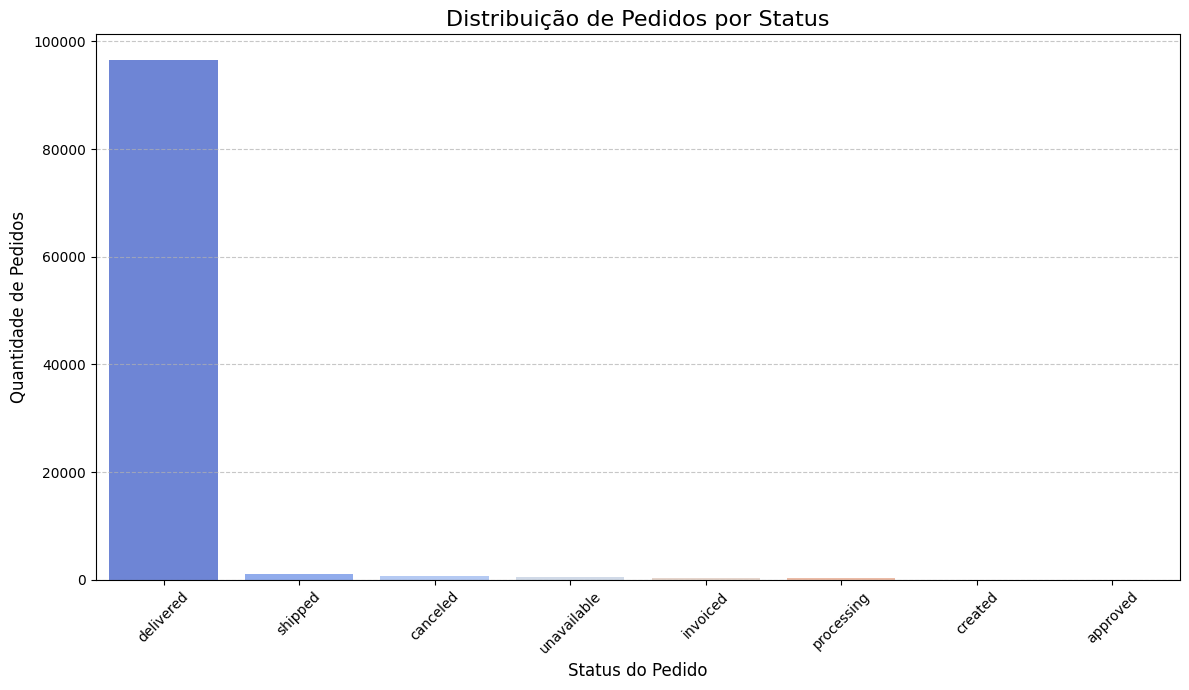

In [10]:
status_pedidos_df = dfs['olist_orders'].groupBy('order_status').count().orderBy('count', ascending=False)

status_pedidos_pd = status_pedidos_df.toPandas()

plt.figure(figsize=(12, 7))
sns.barplot(data=status_pedidos_pd, x='order_status', y='count', palette='coolwarm', hue='order_status', legend=False)
plt.title('Distribuição de Pedidos por Status', fontsize=16)
plt.xlabel('Status do Pedido', fontsize=12)
plt.ylabel('Quantidade de Pedidos', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### 3.2. Comportamento do Consumidor: Preferência Absoluta pelo Cartão de Crédito

**Pergunta de Negócio:** Como os clientes da Olist preferem pagar por suas compras?

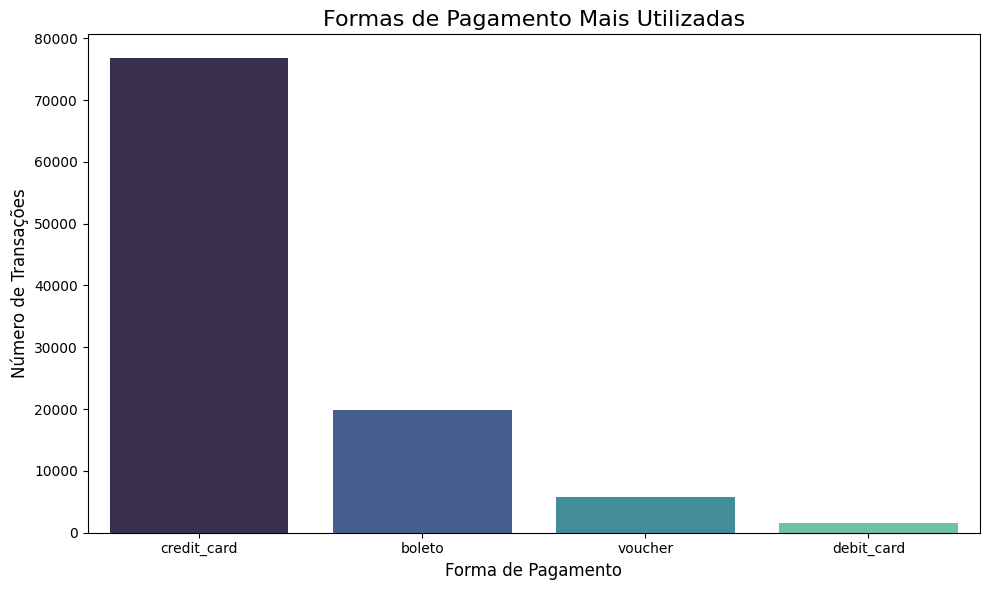

In [11]:
tipos_pagamento_df = dfs['olist_order_payments'].filter(F.col('payment_type') != 'not_defined').groupBy('payment_type').count().orderBy('count', ascending=False)

tipos_pagamento_pd = tipos_pagamento_df.toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(data=tipos_pagamento_pd, x='payment_type', y='count', palette='mako', hue='payment_type', legend=False)
plt.title('Formas de Pagamento Mais Utilizadas', fontsize=16)
plt.xlabel('Forma de Pagamento', fontsize=12)
plt.ylabel('Número de Transações', fontsize=12)
plt.tight_layout()
plt.show()

### 3.3. Análise das avaliações: Distribuição das avaliações dos produtos

**Pergunta de Negócio:** Os produtos atendem as necessidades dos clientes?

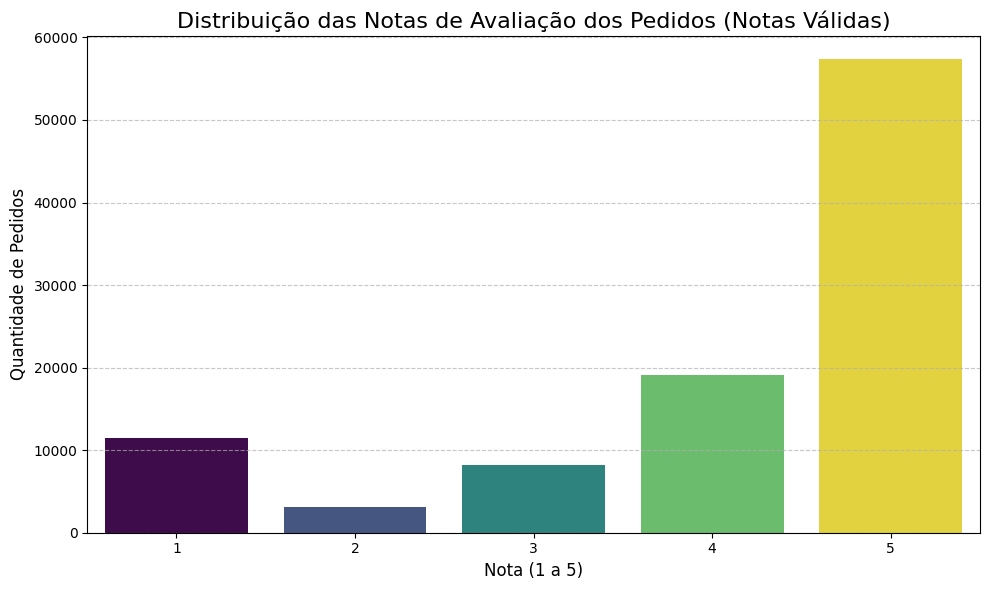

In [12]:
reviews_df_limpo = dfs['olist_order_reviews'].withColumn(
    "review_score_clean",
    F.expr("try_cast(review_score as int)")
)

review_scores_contagem_df = reviews_df_limpo.filter(
    (F.col("review_score_clean").isNotNull()) &
    (F.col("review_score_clean").between(1, 5))
).groupBy('review_score_clean').count().orderBy('review_score_clean')

review_scores_pd = review_scores_contagem_df.toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(
    data=review_scores_pd, 
    x='review_score_clean', 
    y='count', 
    palette='viridis', 
    hue='review_score_clean',
    legend=False
)
plt.title('Distribuição das Notas de Avaliação dos Pedidos (Notas Válidas)', fontsize=16)
plt.xlabel('Nota (1 a 5)', fontsize=12)
plt.ylabel('Quantidade de Pedidos', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### 3.4. Estratégia de Vendas: Foco nas Categorias de Alta Demanda

**Pergunta de Negócio:** Quais são as categorias de produtos que impulsionam as vendas na plataforma?

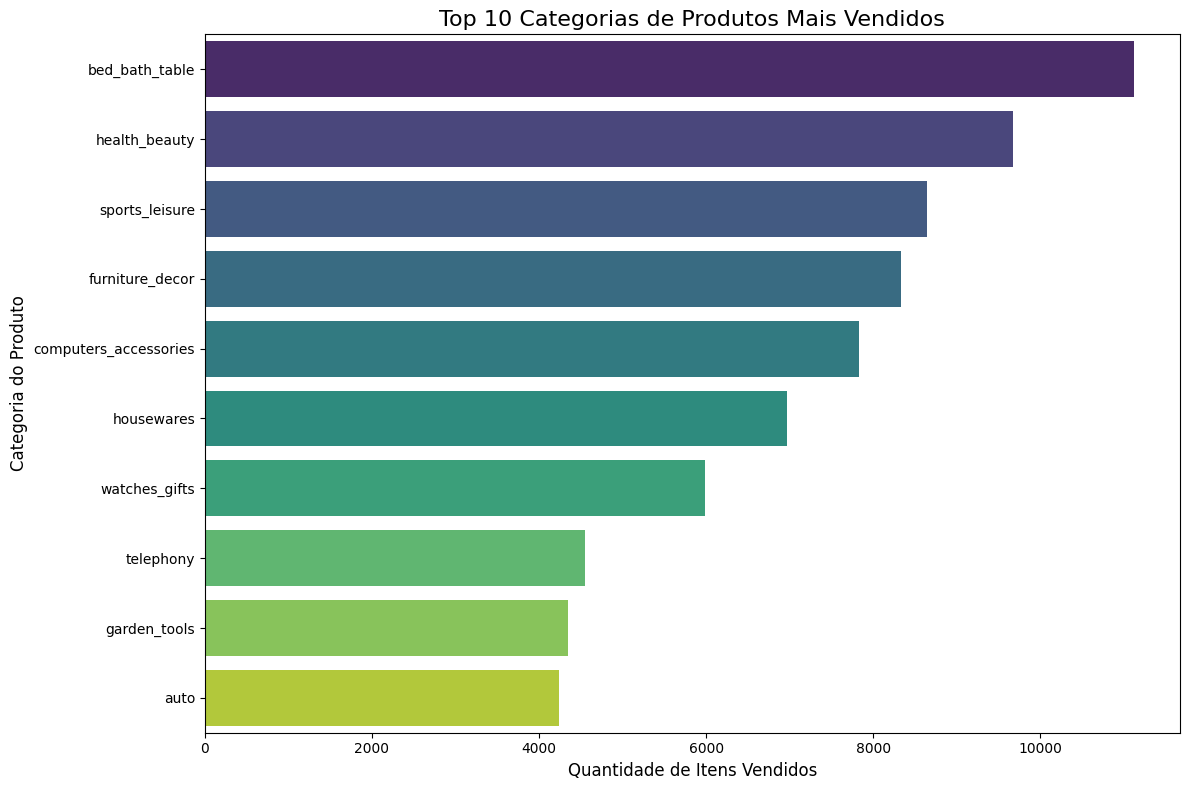

In [13]:
produtos_df = dfs['olist_products']
itens_df = dfs['olist_order_items']
traducao_df = dfs['product_category_name_translation']

top_categorias_df = itens_df.join(
    produtos_df, 
    itens_df.product_id == produtos_df.product_id, 
    'inner'
).join(
    traducao_df,
    produtos_df.product_category_name == traducao_df.product_category_name,
    'left'
).groupBy('product_category_name_english') \
 .count() \
 .orderBy('count', ascending=False) \
 .limit(10)

top_categorias_pd = top_categorias_df.toPandas()

plt.figure(figsize=(12, 8))
sns.barplot(data=top_categorias_pd, y='product_category_name_english', x='count', palette='viridis', hue='product_category_name_english', legend=False)
plt.title('Top 10 Categorias de Produtos Mais Vendidos', fontsize=16)
plt.xlabel('Quantidade de Itens Vendidos', fontsize=12)
plt.ylabel('Categoria do Produto', fontsize=12)
plt.tight_layout()
plt.show()

In [14]:
spark.stop()

## 4. Plano de Ação para o ETL (Camada Prata)

Com base nas descobertas da análise exploratória, foi definida a seguinte especificação técnica para a construção do pipeline de Extração, Transformação e Carga (ETL). As tarefas abaixo são mandatórias para transformar os dados brutos da camada Bronze em um conjunto de dados limpo, coeso e enriquecido na camada Prata, pronto para a modelagem do Data Warehouse.

### 4.1. Unificação dos Dados e Estratégia de JOINs
O objetivo central é a criação de uma tabela única e denormalizada. A unificação será realizada através de uma sequência de `LEFT JOINs` para garantir que nenhum registro de item de pedido seja perdido, mesmo que não haja correspondência em tabelas secundárias (como avaliações ou pagamentos).

-   **Tabela Base:** A `olist_order_items` servirá como a espinha dorsal da junção.
-   **Sequência de Junções:**
    1.  Juntar com `olist_orders` (usando `order_id`).
    2.  Juntar com `olist_products` (usando `product_id`).
    3.  Juntar com `olist_customers` (usando `customer_id` da tabela `olist_orders`).
    4.  Juntar com `olist_sellers` (usando `seller_id`).
    5.  Juntar com as tabelas de `olist_order_payments` e `olist_order_reviews` (ambas usando `order_id`).
    6.  Juntar com `product_category_name_translation` para traduzir os nomes das categorias.

### 4.2. Limpeza e Tratamento de Dados (Data Cleaning)
A análise revelou pontos críticos de qualidade de dados que serão tratados da seguinte forma:

-   **Coluna `review_score`:** A limpeza desta coluna é prioritária. O ETL irá implementar a seguinte lógica:
    1.  Utilizar a função `try_cast` para converter a coluna para o tipo `inteiro`. Esta abordagem garante que valores textuais ou malformados se tornem `NULL` sem gerar erros.
    2.  Filtrar o resultado para manter apenas as notas válidas (valores entre 1 e 5), descartando os `NULL`s.

-   **Valores Nulos em Datas:** Colunas de timestamp como `order_approved_at` e `order_delivered_customer_date` possuem valores nulos. A regra de negócio é **manter esses nulos**, pois eles têm significado operacional (ex: um pedido cancelado não possui data de entrega).

-   **Valores Nulos em Categorias:** A coluna `product_category_name` possui valores nulos. A estratégia de tratamento será substituir os `NULL`s por um valor padrão, como `'desconhecida'`, para garantir a consistência.

-   **Outras Inconsistências:** Tratar valores anômalos identificados, como a categoria `'not_defined'` na tabela de pagamentos, que serão filtrados ou mapeados para `NULL` durante a transformação.